In [ ]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import uniform

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import seaborn as sns
import matplotlib.pyplot as plt



```python
m = nn.BatchNorm2d(3)
input = torch.randn(1, 3, 35, 45)
output = m(input)
```



In [ ]:
dataset = datasets.MNIST(
    root='../datasets',
    download=True,
    train = True,
    transform=transforms.ToTensor()
)

loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=512,
    shuffle=True
)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class SimpleNetBN(nn.Module):
    def __init__(self):
        super(SimpleNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class SimpleNetIN(nn.Module):
    def __init__(self):
        super(SimpleNetIN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
net_without_batch_norm = SimpleNet()

In [ ]:
net_with_batch_norm = SimpleNetBN()

In [ ]:
net_with_instance_norm = SimpleNetIN()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(net_without_batch_norm.parameters(), lr=0.01)
opt_bn = optim.SGD(net_with_batch_norm.parameters(), lr=0.01)
opt_in = optim.SGD(net_with_instance_norm.parameters(), lr=0.01)

[1,   512] loss: 0.057  loss_bn: 0.061
[1, 20992] loss: 2.296  loss_bn: 1.783
[1, 41472] loss: 2.285  loss_bn: 1.214
[2,   512] loss: 0.057  loss_bn: 0.021
[2, 20992] loss: 2.260  loss_bn: 0.744
[2, 41472] loss: 2.239  loss_bn: 0.625
[3,   512] loss: 0.055  loss_bn: 0.011
[3, 20992] loss: 2.184  loss_bn: 0.488
[3, 41472] loss: 2.143  loss_bn: 0.451
[4,   512] loss: 0.051  loss_bn: 0.009
[4, 20992] loss: 2.021  loss_bn: 0.388
[4, 41472] loss: 1.933  loss_bn: 0.360
[5,   512] loss: 0.044  loss_bn: 0.009
[5, 20992] loss: 1.711  loss_bn: 0.321
[5, 41472] loss: 1.587  loss_bn: 0.322
[6,   512] loss: 0.035  loss_bn: 0.007
[6, 20992] loss: 1.333  loss_bn: 0.288
[6, 41472] loss: 1.217  loss_bn: 0.280
[7,   512] loss: 0.028  loss_bn: 0.006
[7, 20992] loss: 1.038  loss_bn: 0.263
[7, 41472] loss: 0.959  loss_bn: 0.258
[8,   512] loss: 0.022  loss_bn: 0.007
[8, 20992] loss: 0.841  loss_bn: 0.242
[8, 41472] loss: 0.798  loss_bn: 0.235
[9,   512] loss: 0.020  loss_bn: 0.006
[9, 20992] loss: 0.718  l

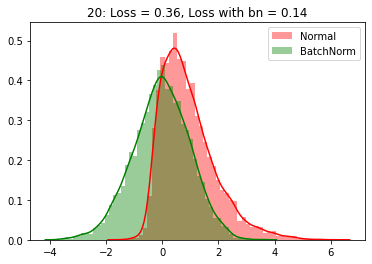

----------------------


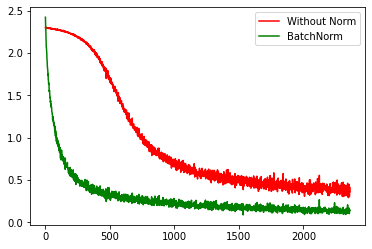

In [ ]:
loss_arr = []
loss_bn_arr = []

max_epochs = 20

for epoch in range(max_epochs):
    
    running_loss = 0.0
    running_loss_bn = 0.0
    for i, data in enumerate(loader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = net_without_batch_norm(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = net_with_batch_norm(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        # print statistics
        running_loss += loss.item()
        running_loss_bn += loss_bn.item()
        if i % 40 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f  loss_bn: %.3f'%
                  (epoch + 1, (i + 1)*512, running_loss / 40, running_loss_bn / 40))
            running_loss = 0.0
            running_loss_bn = 0.0
    print("="*40)
            

print("="*10 + " Epoch {} ".format(epoch+1) + "="*10)
inputs = inputs.view(inputs.size(0), -1)

net_without_batch_norm.eval()
net_with_batch_norm.eval()

a = net_without_batch_norm.classifier[0](inputs)
a = a.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Normal') 

b = net_with_batch_norm.classifier[0](inputs)
b = net_with_batch_norm.classifier[1](b)
b = b.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='BatchNorm') 

plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (epoch+1, loss.item(), loss_bn.item()))
plt.legend()
plt.savefig("activation-distribution.png", dpi=100)
plt.show()
plt.pause(0.5)

net_without_batch_norm.train()
net_with_batch_norm.train()
print('----------------------')

plt.plot(loss_arr, 'r', label='Without Norm')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.savefig("training-loss.png", dpi=100)
plt.legend()
plt.show()

---

In [ ]:
%%capture
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimgd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#height, width = 100, 100
#array = np.round(np.random.rand(height, width, 3) * 255).astype(np.uint8)
#img = Image.fromarray(array)
#img.save('img.png')

#img_tensor_copy = img_tensor.detach().clone()
#img_tensor_copy.shape

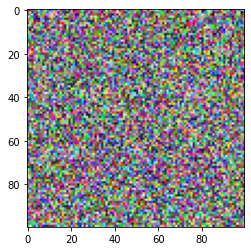

In [ ]:
img = mpimg.imread('img.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img = mpimg.imread('img.png')
img = np.transpose(img,(2,0,1))
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.type('torch.FloatTensor')
img_tensor = img_tensor.unsqueeze(0)

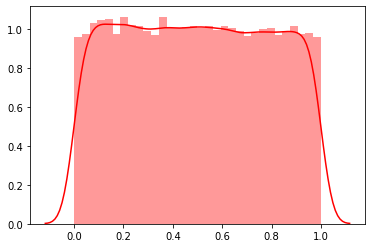

In [ ]:
a = img_tensor.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Img_Tensor_batch_norm') 

In [ ]:
conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4)
conv_output_1 = conv_layer_1(img_tensor)
conv_output_1.shape

torch.Size([1, 16, 97, 97])

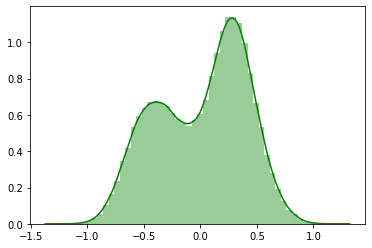

In [ ]:
b = conv_output_1.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='Conv_1_output') 

In [ ]:
batch_norm_layer = nn.BatchNorm2d(16)
batch_norm_output = batch_norm_layer(conv_output_1)
batch_norm_output.shape

torch.Size([1, 16, 97, 97])

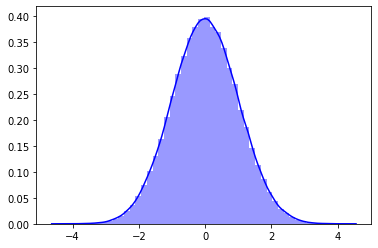

In [ ]:
c = batch_norm_output.detach().numpy().ravel()
sns.distplot(c, kde=True, color='b', label='Batch_Norm_2d_output') 

In [ ]:
img = mpimg.imread('img.png')
img = np.transpose(img,(2,0,1))
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.type('torch.FloatTensor')
img_tensor = img_tensor.unsqueeze(0)

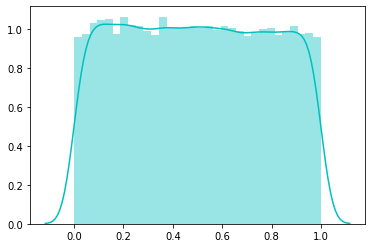

In [ ]:
d = img_tensor.detach().numpy().ravel()
sns.distplot(d, kde=True, color='c', label='Img_Tensor_instance_norm')

In [ ]:
conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4)
conv_output_2 = conv_layer_2(img_tensor)
conv_output_2.shape

torch.Size([1, 16, 97, 97])

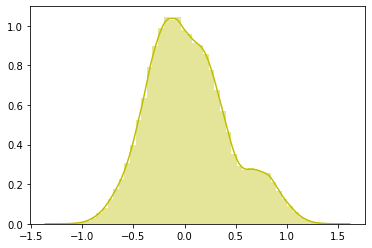

In [ ]:
e = conv_output_2.detach().numpy().ravel()
sns.distplot(e, kde=True, color='y', label='Conv_2_output') 

In [ ]:
instance_norm_layer = nn.InstanceNorm2d(16)
instance_norm_output = instance_norm_layer(conv_output_2)
instance_norm_output.shape

torch.Size([1, 16, 97, 97])

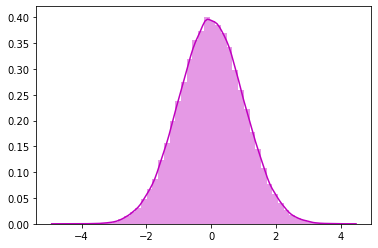

In [ ]:
f = instance_norm_output.detach().numpy().ravel()
sns.distplot(f, kde=True, color='m', label='Instance_norm_output') 

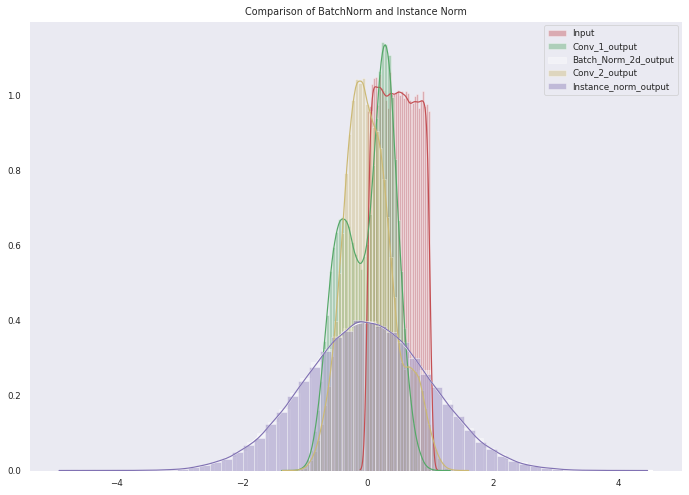

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("dark")
sns.set_context("paper")
a = img_tensor.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Input') 
b = conv_output_1.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='Conv_1_output') 
c = batch_norm_output.detach().numpy().ravel()
sns.distplot(c, kde=True, color='w', label='Batch_Norm_2d_output') 
e = conv_output_2.detach().numpy().ravel()
sns.distplot(e, kde=True, color='y', label='Conv_2_output')
f = instance_norm_output.detach().numpy().ravel()
sns.distplot(f, kde=True, color='m', label='Instance_norm_output')  
plt.title('Comparison of BatchNorm and Instance Norm')
plt.legend()
plt.savefig("comparison.png", dpi=100)
plt.show()
plt.pause(0.5)

---